In [1]:


pip install --upgrade keras tensorflow


   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.1/1.1 MB 5.6 MB/s eta 0:00:0000:0100:010m
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 589.8/589.8 MB 2.5 MB/s eta 0:00:00:00:0100:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.2/2.2 MB 59.6 MB/s eta 0:00:00:00:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 5.5/5.5 MB 66.6 MB/s eta 0:00:00:00:0100:01
  Attempting uninstall: ml-dtypes
    Found existing installation: ml-dtypes 0.2.0
    Uninstalling ml-dtypes-0.2.0:
      Successfully uninstalled ml-dtypes-0.2.0
  Attempting uninstall: tensorboard
    Found existing installation: tensorboard 2.15.1
    Uninstalling tensorboard-2.15.1:
      Successfully uninstalled tensorboard-2.15.1
  Attempting uninstall: keras
    Found existing installation: keras 3.2.1
    Uninstalling keras-3.2.1:
      Successfully uninstalled keras-3.2.1
  Attempting uninstall: tensorflow
    Found existing installation: tensorflow 2.15.0
    Uninstalling tensorflow-2.15.0:
      Successfully uninstalled tensorflow

In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import seaborn as sns
%matplotlib inline

np.random.seed(2)

from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix
import itertools

from keras.layers import *
from keras.optimizers import Adam
from keras.regularizers import l2
from keras.utils import to_categorical

# convert to one-hot-encoding
# from keras.preprocessing.image import ImageDataGenerator
from keras.callbacks import ReduceLROnPlateau, ModelCheckpoint
from keras.models import Model, load_model, save_model, Sequential
from keras.layers import Dense, Dropout, Flatten, Conv2D, MaxPooling2D, Conv2DTranspose
from keras.layers import Activation, Dropout, Input, Masking, TimeDistributed, LSTM, Conv1D
from keras.layers import GRU, Bidirectional, BatchNormalization, Reshape
from keras.optimizers import Adam, RMSprop

sns.set(style='white', context='notebook', palette='deep')


In [3]:
import os
import numpy as np       # linear algebra
import pandas as pd      # data processing, CSV file I/O (e.g. pd.read_csv)
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from glob import glob    # finds all the pathnames matching a specified pattern according to the rules used by the Unix shell
from skimage.util import montage 
from skimage.io   import imread
%matplotlib inline

# Locate all the image and mask files 

In [4]:
BASE_IMG_PATH = os.path.join('..','input/finding-lungs-in-ct-data/')
DS_FACT = 2
SEED=42

all_image_files = glob(os.path.join(BASE_IMG_PATH,'2d_images','*.tif'))
all_mask_files  = glob(os.path.join(BASE_IMG_PATH,'2d_masks','*.tif'))

print('No. of images:', len(all_image_files))
print(all_image_files[0])
print(all_mask_files[0])

No. of images: 267
../input/finding-lungs-in-ct-data/2d_images/ID_0055_Z_0122.tif
../input/finding-lungs-in-ct-data/2d_masks/ID_0055_Z_0122.tif


# Load an image and check it out ... 

(1, 256, 256)


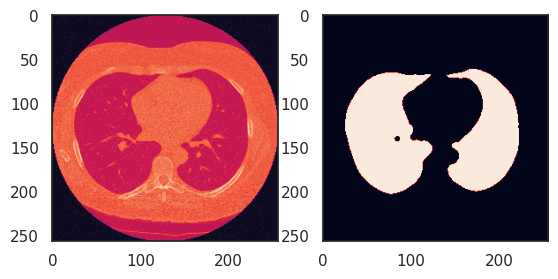

In [5]:
test_image = np.expand_dims(imread(all_image_files[0])[::2, ::2],0)
test_mask  = np.expand_dims(imread(all_mask_files[0])[::2, ::2],0)/255.0
fig, (ax1 ,ax2) = plt.subplots(1, 2)
ax1.imshow(test_image[0])
ax2.imshow(test_mask[0])
print(test_image.shape)

Load all the images and masks

In [6]:
images = np.stack([np.expand_dims(imread(i)[::DS_FACT, ::DS_FACT], -1) for i in all_image_files], axis=0)
masks = np.stack([np.expand_dims(imread(i)[::DS_FACT, ::DS_FACT] / 255., -1) for i in all_mask_files], axis=0)

X_train, X_test, y_train, y_test = train_test_split(images, masks, test_size=0.1)

print('X_train - len/shape:', len(X_train), X_train.shape)
print('Y_train is {}, min is {}, max is {}, mean is {}'.format(y_train.shape, y_train.min(), y_train.max(), y_train.mean()))
print('X_test  - len/shape:', len(X_test), y_test.shape)
print(images.shape[:])


X_train - len/shape: 240 (240, 256, 256, 1)
Y_train is (240, 256, 256, 1), min is 0.0, max is 1.0, mean is 0.23500232696533202
X_test  - len/shape: 27 (27, 256, 256, 1)
(267, 256, 256, 1)


# Define the UNET 

In [8]:
from keras.models import Model
from keras.layers import Input, Conv2D, MaxPooling2D, UpSampling2D
from keras.layers import concatenate, Conv2DTranspose, BatchNormalization, Dropout, Activation, Add
from keras.optimizers import Adam
from tensorflow.keras.metrics import MeanIoU
from keras.initializers import he_normal
from keras import backend as K
from keras.regularizers import l2
from keras.callbacks import ReduceLROnPlateau






def conv_block(input, num_filters):
    x = Conv2D(num_filters, 3, padding="same", 
               kernel_initializer=he_normal())(input)  # Add L2 regularization here
    x = BatchNormalization()(x)
    x = Activation("relu")(x)
    x = Dropout(0.08)(x)

    x = Conv2D(num_filters, 3, padding="same", 
               kernel_initializer=he_normal())(x)  # Add L2 regularization here
    x = BatchNormalization()(x)
    x = Activation("relu")(x)
    x = Dropout(0.08)(x)

    return x

def residual_block(layer_input, num_filters):
    x = conv_block(layer_input, num_filters)
    x = conv_block(x, num_filters)
    residual = Conv2D(num_filters, 1, padding="same", kernel_initializer=he_normal())(layer_input)
    residual = Dropout(0.08)(residual)
    x = Add()([x, residual])
    return x

def encoder_block(input, num_filters):
    x = conv_block(input, num_filters)
    p = MaxPooling2D((2, 2))(x)
    return x, p

def decoder_block(input, skip_features, num_filters):
    x = Conv2DTranspose(num_filters, (2, 2), strides=2, padding="same")(input)
    x = Dropout(0.08)(x)
    x = concatenate([x, skip_features])
    x = conv_block(x, num_filters)
    return x

def build_unet(input_shape, n_classes):
    inputs = Input(input_shape)

    s1, p1 = encoder_block(inputs, 32)
    s2, p2 = encoder_block(p1, 64)
    s3, p3 = encoder_block(p2, 128)
    s4, p4 = encoder_block(p3, 256)

    b1 = residual_block(p4, 512) # Bridge with residual block

    d1 = decoder_block(b1, s4, 256)
    d2 = decoder_block(d1, s3, 128)
    d3 = decoder_block(d2, s2, 64)
    d4 = decoder_block(d3, s1, 32)

    if n_classes == 1:
        activation = 'sigmoid'
    else:
        activation = 'softmax'

    outputs = Conv2D(n_classes, 1, padding="same", activation=activation)(d4)
    print(activation)

    model = Model(inputs, outputs, name="U-Net")
    return model


input_shape = (128, 128, 3)
# Define a learning rate reduction callback
# reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=5, min_lr=1e-7)

model = build_unet(input_shape, n_classes=1)


sigmoid


# Define the model

In [11]:
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf
import tensorflow.keras.layers as L
# Define the input shape based on the shape of your input data
input_shape = X_train.shape[1:]

# Create the input layer with the specified input shape
inputs = L.Input(shape=input_shape, name="input_layer")

# Call the unet3plus function with the input layer
model = build_unet(input_shape, n_classes=1)



model.compile(optimizer=Adam(), loss="binary_crossentropy", metrics=["accuracy"])
print(model.summary())

sigmoid


Model: "U-Net"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer_3       │ (None, 256, 256,  │          0 │ -                 │
│ (InputLayer)        │ 1)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_44 (Conv2D)  │ (None, 256, 256,  │        320 │ input_layer_3[0]… │
│                     │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 256, 256,  │        128 │ conv2d_44[0][0]   │
│ (BatchNormalizatio… │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ activation_40       │ (None, 256, 256,  │          0 │ batch_normalizat… │
│ (Activation)        │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout_50          │ (None, 256, 256,  │          0 │ activation_40[0]… │
│ (Dropout)           │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_45 (Conv2D)  │ (None, 256, 256,  │      9,248 │ dropout_50[0][0]  │
│                     │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 256, 256,  │        128 │ conv2d_45[0][0]   │
│ (BatchNormalizatio… │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ activation_41       │ (None, 256, 256,  │          0 │ batch_normalizat… │
│ (Activation)        │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout_51          │ (None, 256, 256,  │          0 │ activation_41[0]… │
│ (Dropout)           │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ max_pooling2d_8     │ (None, 128, 128,  │          0 │ dropout_51[0][0]  │
│ (MaxPooling2D)      │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_46 (Conv2D)  │ (None, 128, 128,  │     18,496 │ max_pooling2d_8[… │
│                     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 128, 128,  │        256 │ conv2d_46[0][0]   │
│ (BatchNormalizatio… │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ activation_42       │ (None, 128, 128,  │          0 │ batch_normalizat… │
│ (Activation)        │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout_52          │ (None, 128, 128,  │          0 │ activation_42[0]… │
│ (Dropout)           │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_47 (Conv2D)  │ (None, 128, 128,  │     36,928 │ dropout_52[0][0]  │
│                     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 128, 128,  │        256 │ conv2d_47[0][0]   │
│ (BatchNormalizatio… │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ activation_43       │ (None, 128, 128,  │          0 │ batch_normalizat

 Total params: 12,626,593 (48.17 MB)

 Trainable params: 12,618,657 (48.14 MB)

 Non-trainable params: 7,936 (31.00 KB)

None


In [12]:
from keras.callbacks import EarlyStopping, ModelCheckpoint, ReduceLROnPlateau
callbacks = [
    EarlyStopping(patience=10, verbose=1),
    ReduceLROnPlateau(factor=0.1, patience=3, min_lr=0.00001, verbose=1),
    ModelCheckpoint('model-lung.weights.h5', verbose=1, save_best_only=True, save_weights_only=True)
]



In [13]:
history = model.fit(X_train, y_train, batch_size=10, epochs=24, callbacks=callbacks, \
                    validation_data=(X_test, y_test))

Epoch 1/24


I0000 00:00:1715318182.483545     127 service.cc:145] XLA service 0x7e3d380022c0 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
I0000 00:00:1715318182.483620     127 service.cc:153]   StreamExecutor device (0): Tesla T4, Compute Capability 7.5
I0000 00:00:1715318182.483628     127 service.cc:153]   StreamExecutor device (1): Tesla T4, Compute Capability 7.5
I0000 00:00:1715318258.433604     127 device_compiler.h:188] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.


24/24 ━━━━━━━━━━━━━━━━━━━━ 0s 210ms/step - accuracy: 0.8195 - loss: 0.4009
Epoch 1: val_loss improved from inf to 38.14964, saving model to model-lung.weights.h5
24/24 ━━━━━━━━━━━━━━━━━━━━ 103s 569ms/step - accuracy: 0.8227 - loss: 0.3956 - val_accuracy: 0.7619 - val_loss: 38.1496 - learning_rate: 0.0010
Epoch 2/24
24/24 ━━━━━━━━━━━━━━━━━━━━ 0s 212ms/step - accuracy: 0.9785 - loss: 0.1097
Epoch 2: val_loss did not improve from 38.14964
24/24 ━━━━━━━━━━━━━━━━━━━━ 5s 219ms/step - accuracy: 0.9785 - loss: 0.1094 - val_accuracy: 0.6565 - val_loss: 55.1744 - learning_rate: 0.0010
Epoch 3/24
24/24 ━━━━━━━━━━━━━━━━━━━━ 0s 212ms/step - accuracy: 0.9831 - loss: 0.0819
Epoch 3: val_loss improved from 38.14964 to 2.18884, saving model to model-lung.weights.h5
24/24 ━━━━━━━━━━━━━━━━━━━━ 6s 243ms/step - accuracy: 0.9833 - loss: 0.0815 - val_accuracy: 0.7622 - val_loss: 2.1888 - learning_rate: 0.0010
Epoch 4/24
24/24 ━━━━━━━━━━━━━━━━━━━━ 0s 212ms/step - accuracy: 0.9897 - loss: 0.0570
Epoch 4: val_l

The validation loss is 0.0267

# Evaluation

In [14]:
def plot_history(history, title):
    plt.figure(figsize=(10,3))
    # Plot training & validation accuracy values
    plt.subplot(121)
    plt.plot(history.history['accuracy'])
    plt.plot(history.history['val_accuracy'])
    plt.title('Model accuracy')
    plt.ylabel('Accuracy')
    plt.xlabel('Epoch')
    plt.legend(['Train', 'Test'], loc='upper left')

    # Plot training & validation loss values
    plt.subplot(122)
    plt.plot(history.history['loss'])
    plt.plot(history.history['val_loss'])
    plt.title('Model loss')
    plt.ylabel('Loss')
    plt.xlabel('Epoch')
    plt.legend(['Train', 'Test'], loc='upper left')
    plt.show()

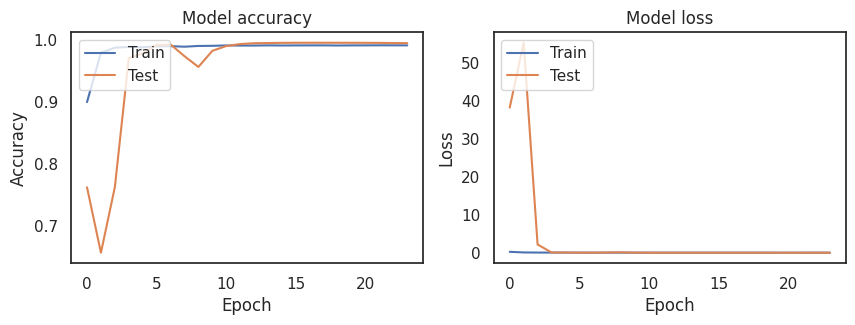

In [15]:
plot_history(history, 'UNet Loss/Accuracy')

In [16]:
model.load_weights('model-lung.weights.h5')

1/1 ━━━━━━━━━━━━━━━━━━━━ 3s 3s/step


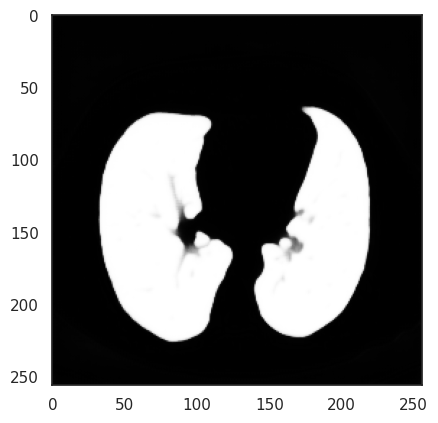

In [17]:
plt.imshow(
    model.predict(X_train[0].reshape(1,256, 256, 1))[0,:,:,0], 
    cmap='gray')

# Show the predictions of all 27 validation cases

1/1 ━━━━━━━━━━━━━━━━━━━━ 19s 19s/step


/tmp/ipykernel_34/1846916490.py:4: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`). Consider using `matplotlib.pyplot.close()`.
  fig, ax = plt.subplots(1,3,figsize=(12,6))


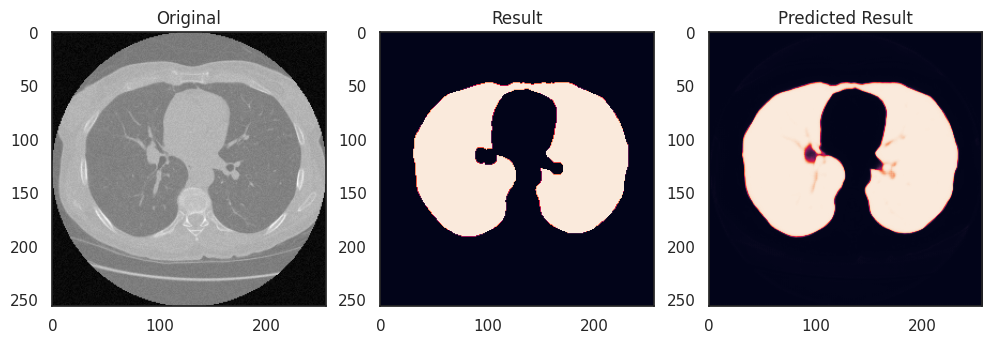

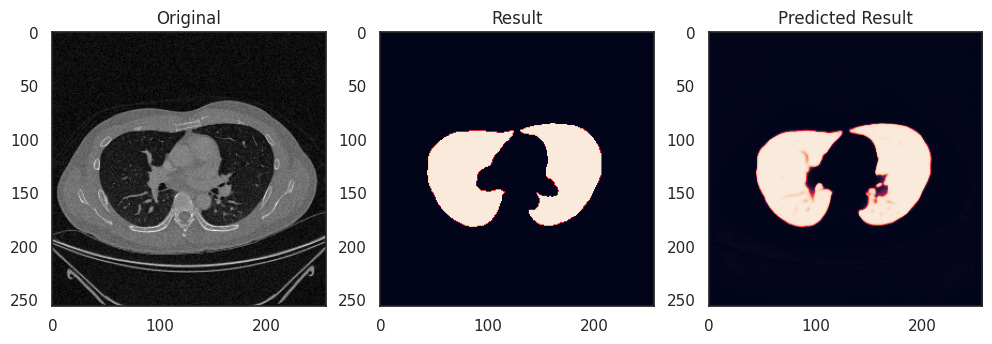

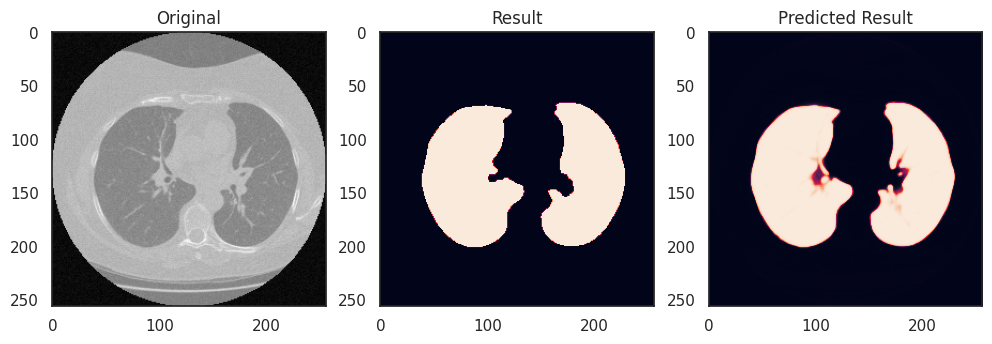

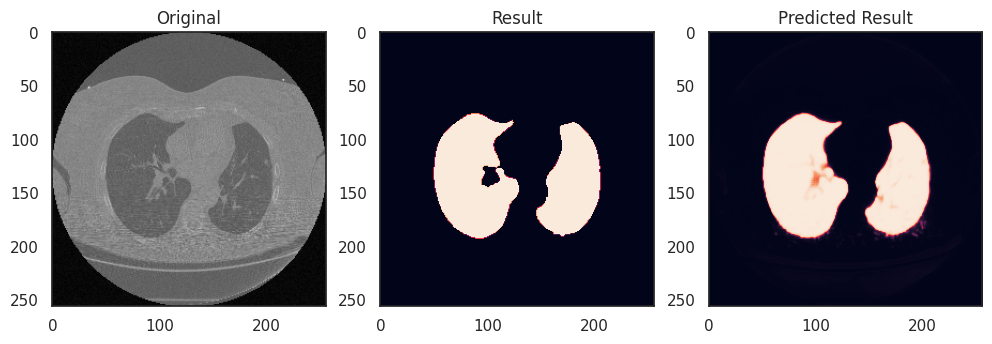

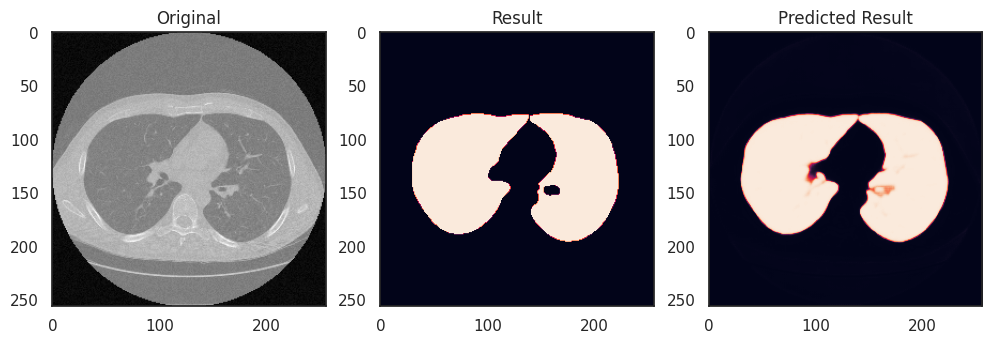

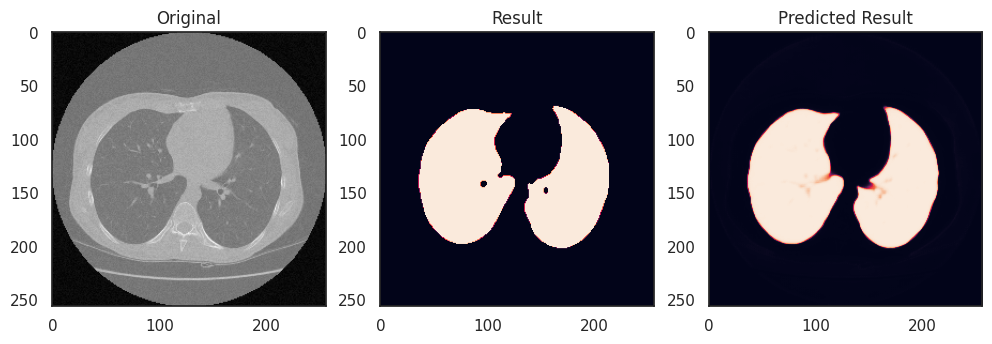

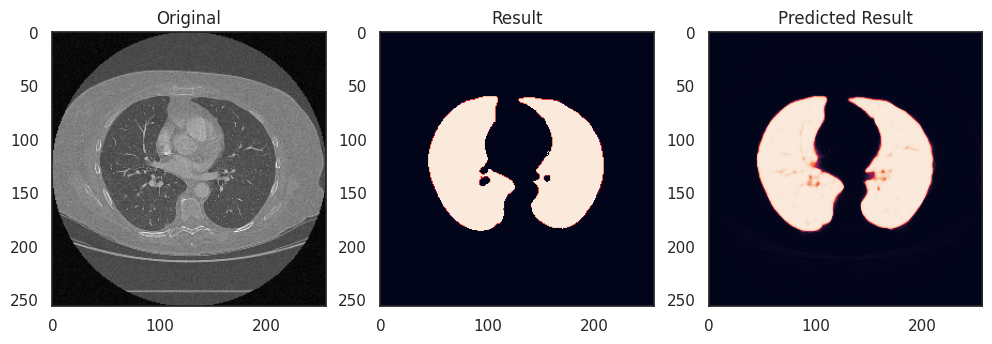

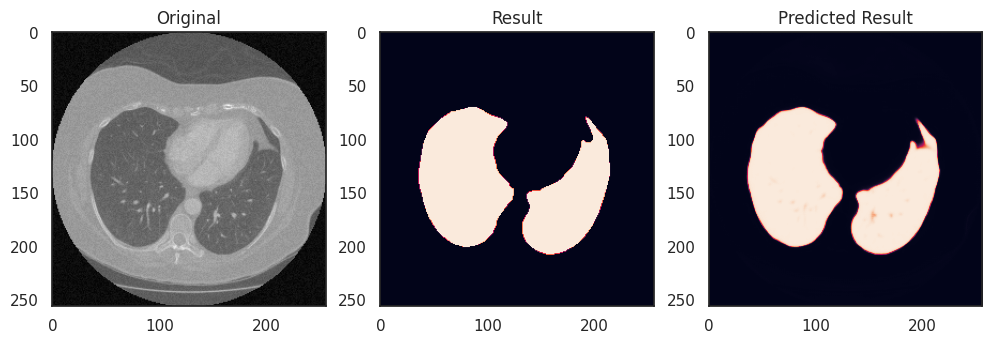

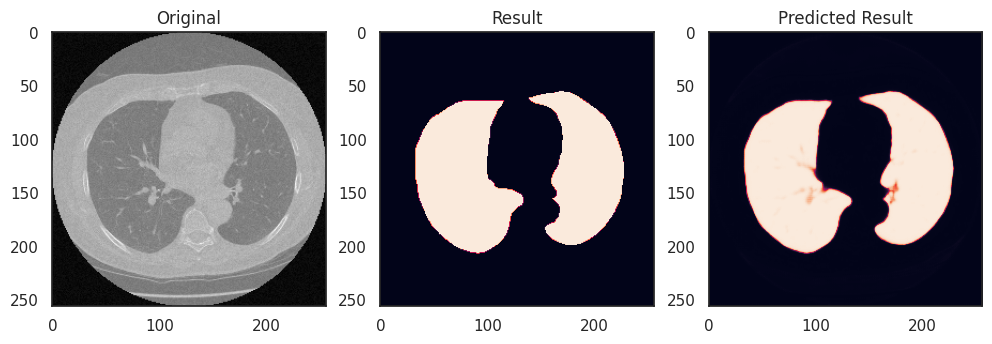

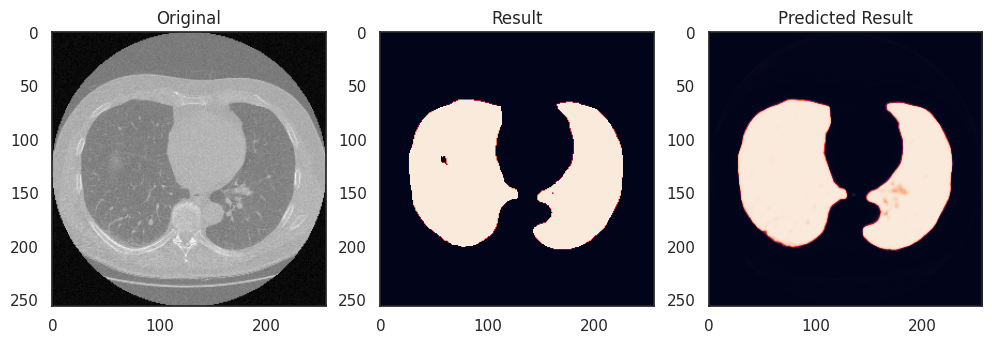

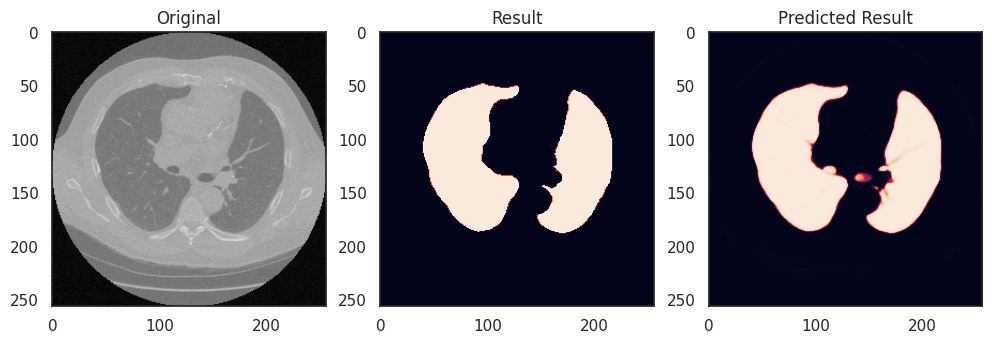

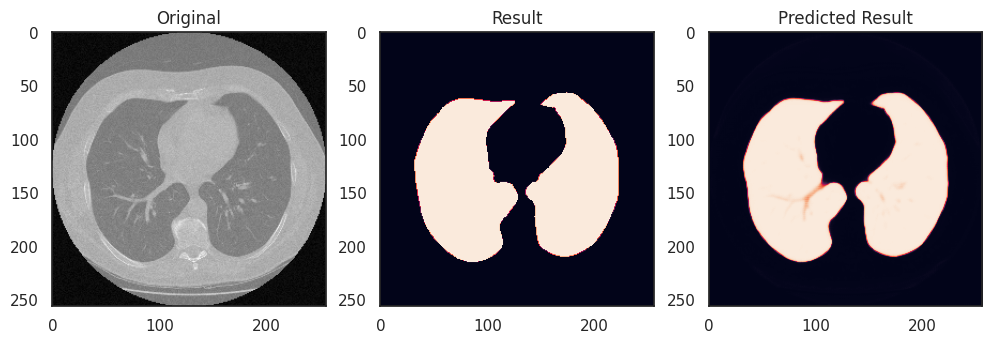

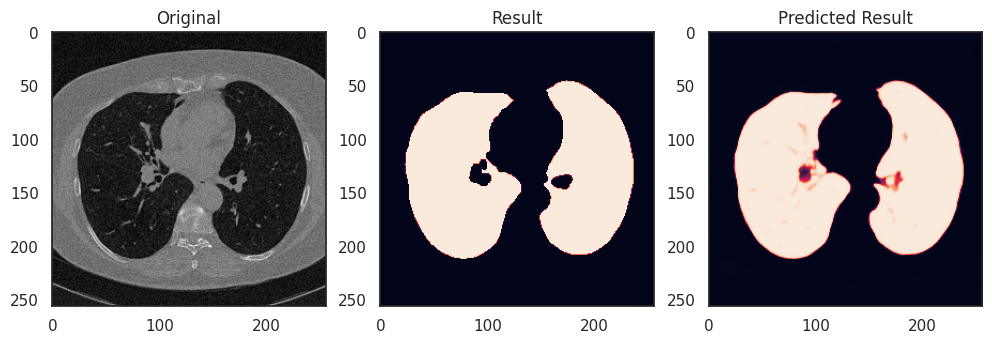

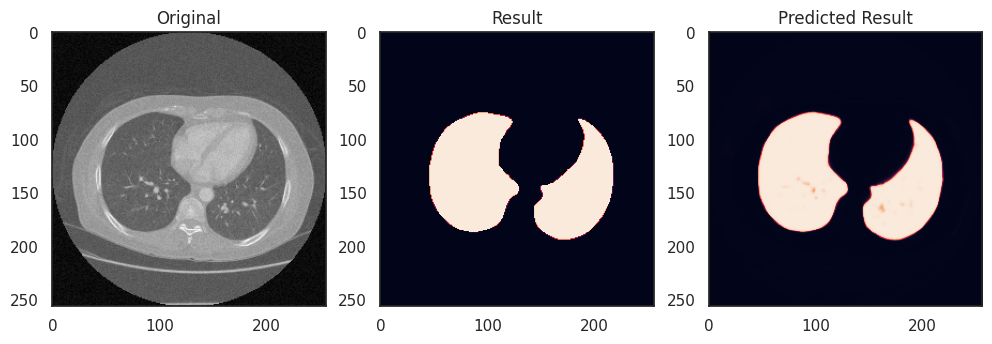

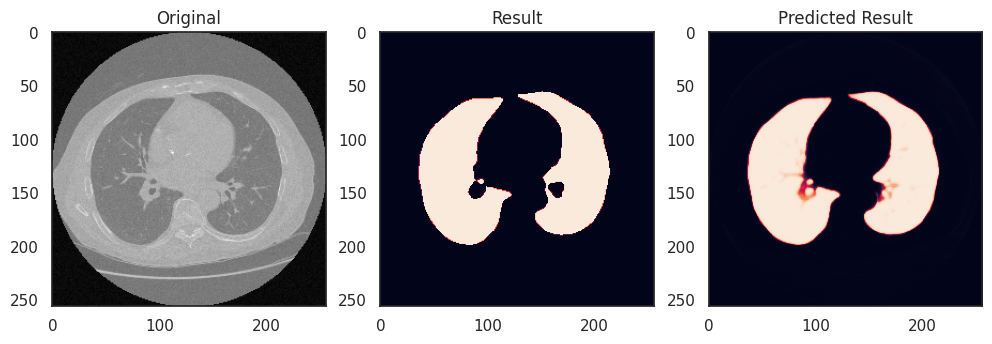

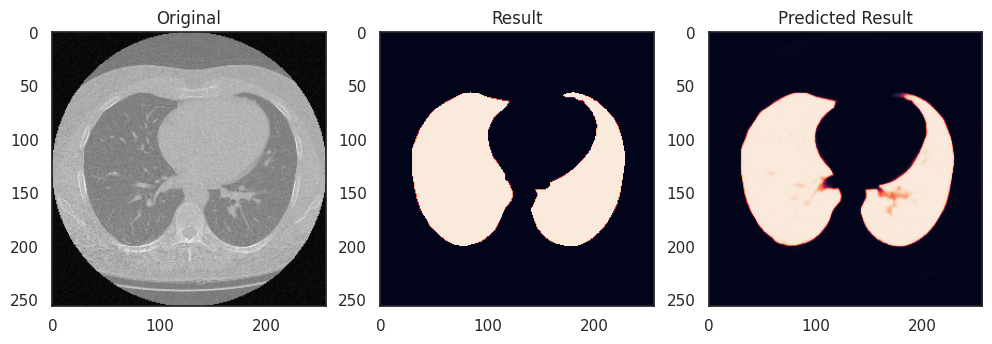

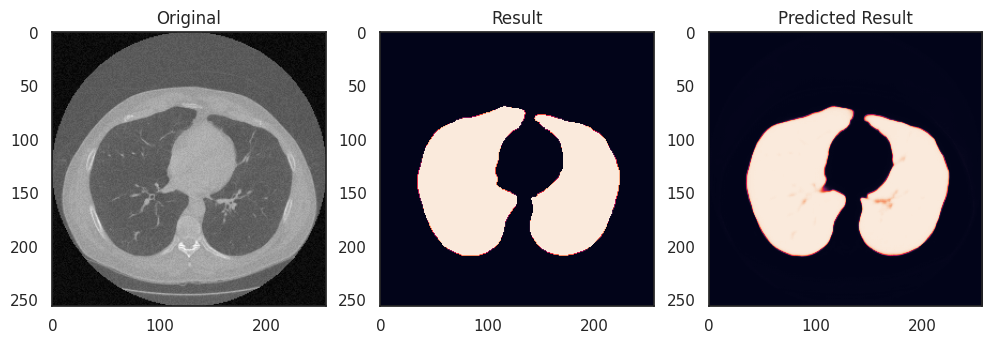

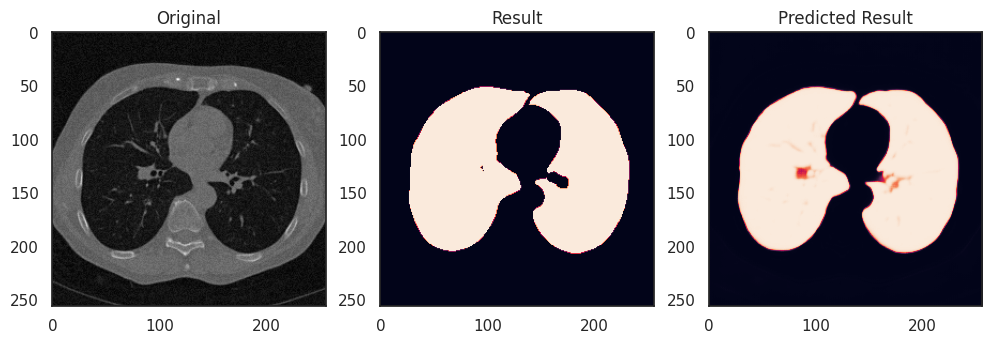

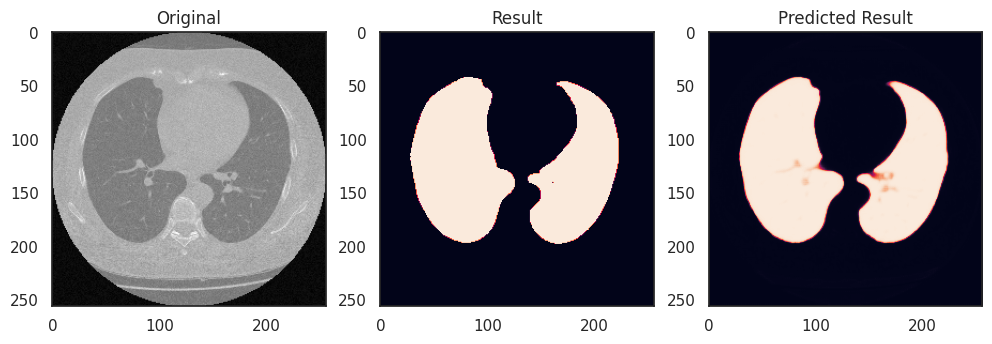

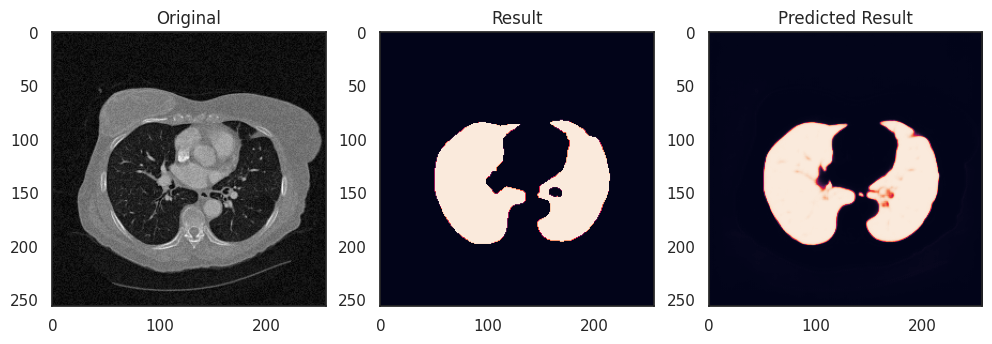

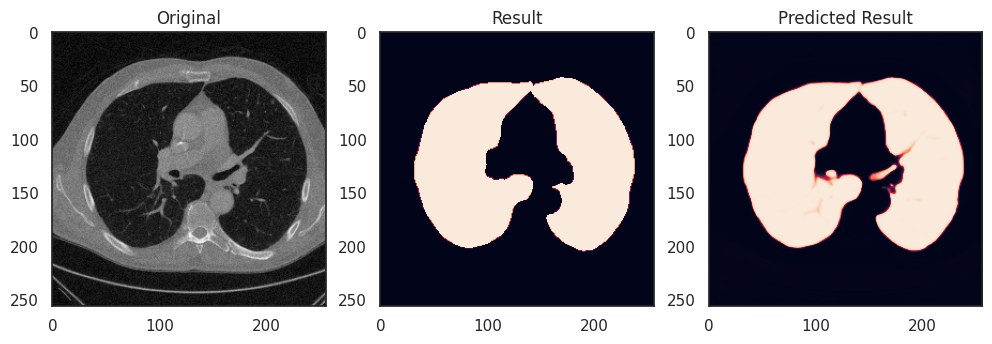

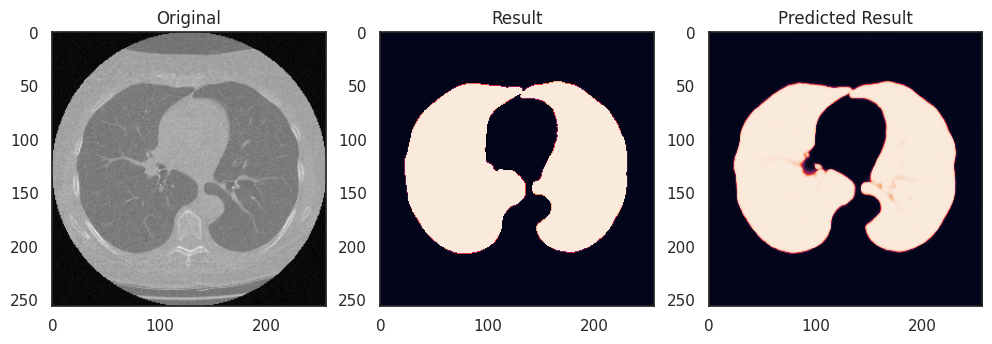

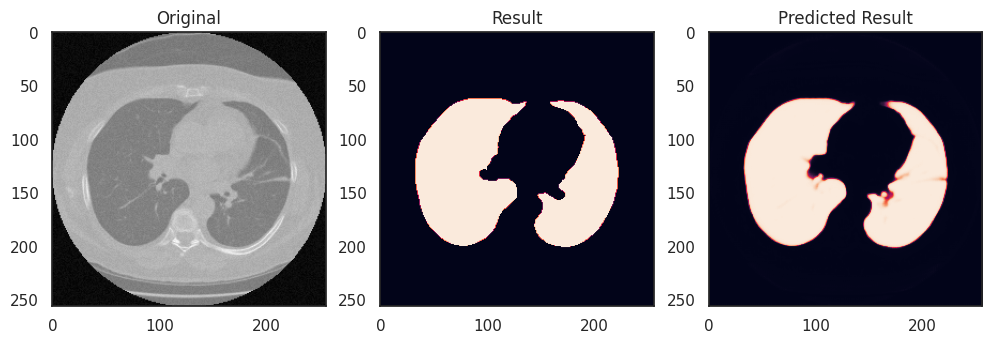

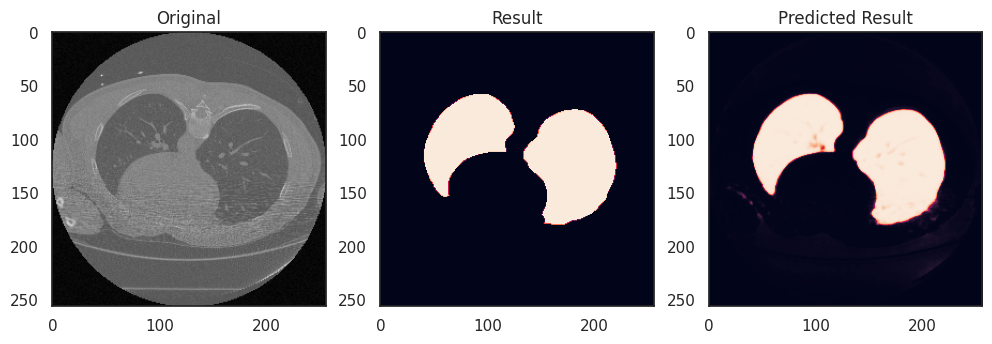

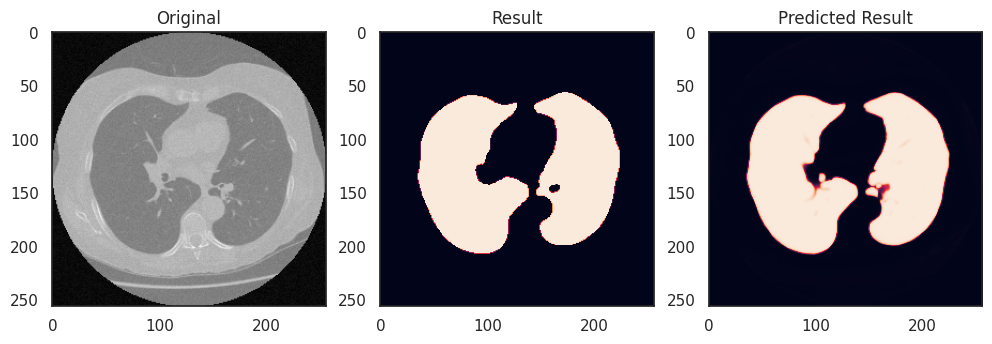

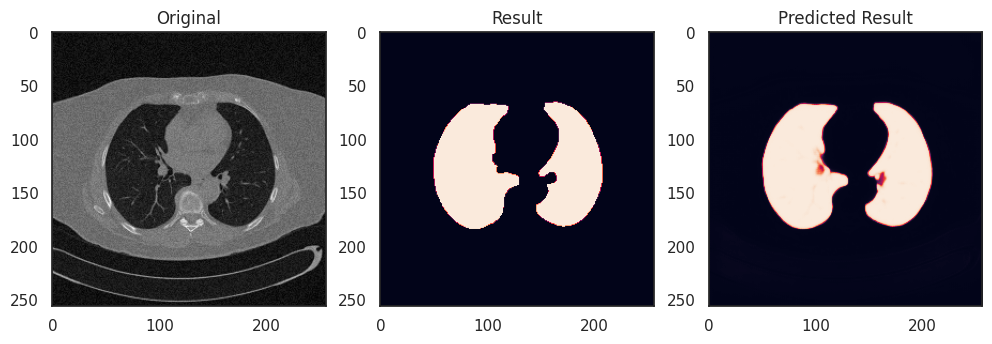

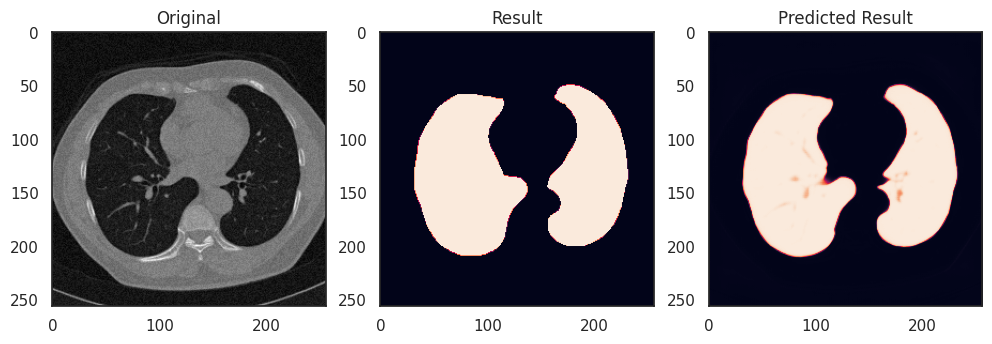

In [18]:
y_predict = model.predict(X_test)

for i in range(X_test.shape[0]): 
    fig, ax = plt.subplots(1,3,figsize=(12,6))
    ax[0].set_title('Original')
    ax[1].set_title('Result')
    ax[2].set_title('Predicted Result')
    ax[0].imshow(X_test[i,:,:,0], cmap='gray')
    ax[1].imshow(y_test[i,:,:,0])
    ax[2].imshow(y_predict[i,:,:,0])